## Вариант 3
Используя библиотеку Natasha, извлечь все фамильно-именные группы и названия организаций из текстов новостей. Построить граф социальной сети для организаций и лиц, упоминавшихся в новостях, считая, что две организации или лица, встретившиеся в одной заметке, связаны между собой. Рассчитать меру посредничества для вершин графа, выделить 10 вершин с самой большой мерой кластерности.

разделитель (5 символов равно) //
URL //
название источника //
дата //
автор //
название статьи //
текст статьи //

http://svetly-put.ru/

In [43]:
import requests
from bs4 import BeautifulSoup
import re
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math
from operator import itemgetter

In [44]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

In [45]:
def extract_date(datetag, date = ''):
    datetag = str(datetag)
    date = re.findall(r'\d{2}.\d{2}.\d{4}', datetag)
    return str(date[0])

In [46]:
def extract_author(authortag, author = ''):
    authortag = str(authortag)
    author = re.findall(r'Автор: (.+?)\t', authortag)
    return str(author[0])

In [47]:
def extract_title(titletag, title = ''):
    titletag = str(titletag)
    title = re.findall(r'\t\t\t\t\t(.+?)\t\t\t', titletag)
    return str(title[0])

In [50]:
def extract_text(texttag, title, text = ''):
    text = re.sub(r'.* \| Сайт газеты','',texttag)
    text = re.sub(r'Поиск по сайту','',text)
    text = re.sub(r'Автор: (.+?)\t','',text)
    text = re.sub(r'\d{2}.\d{2}.\d{4} \d{2}:\d{2}','',text)
    # Текст новости начинается там, где заканчивается текст заголовка, который у нас уже есть
    pattern = re.compile(str(title))
    start = pattern.search(text)
    if start:
        text = text[start.span()[1]:]
    # Текст  новости заканчивается там, где начинаются комментарии
    pattern = re.compile('Комментарии')
    start = pattern.search(text)
    if start:
        text = text[:start.span()[0]]
    # В более старых новостях ещё не было возможности комментирования, поэтому
    # текст новости заканчивается там, где начинается копирайт
    pattern = re.compile('©')
    start = pattern.search(text)
    if start:
        text = text[:start.span()[0]]
    # Очищаем текст от технических  символов
    text = re.sub(r'[\n\t\r]{2,}','', text)
    text = re.sub(r'\xa0','',text)
        
    return text

In [51]:
texts = [] # список текстов для анализа и построения графа
with open('svetly_put_output.txt', 'a', encoding = 'utf-8') as output:
    for i in tqdm(range(1,1754)):
        # Новость 1753 — последняя на момент сбора данных
        if i % 15 == 0:
            time.sleep(3)
        r = requests.get('http://svetly-put.ru/index.php?option=com_content&amp;view=article&amp;id='+str(i), 
                         auth=('user', 'pass'))
        if r.status_code == 200:
            soup = BeautifulSoup(r.text)
            output.write('======\n')
            output.write('http://svetly-put.ru/index.php?option=com_content&amp;view=article&amp;id='+str(i)+'\n')
            output.write('Газета "Светлый путь"\n')
    
            # Ищем тег с датой
            datetag = soup.findAll('td', {"class": "createdate"})
            output.write(extract_date(datetag)+'\n')
    
            # Ищем тег с автором
            authortag = soup.findAll('span', {"class": "small"})
            output.write(extract_author(authortag)+'\n')
    
            # Ищем тег с названием 
            titletag = soup.findAll('td', {"class": "contentheading"})
            title = extract_title(titletag)
            output.write(title+'\n')
    
            # Тег, в котором лежит текст, постоянно разный (а иногда вообще лежит в обычном div или td)
            # Поэтому сначала достанем весь текст из страницы, а потом просто его почистим
            texttag = soup.get_text()
            texts.append(extract_text(texttag, title))
            output.write(texts[-1]+'\n')
            

100%|██████████████████████████████████████████████████████████████████████████████| 1753/1753 [13:33<00:00,  2.16it/s]


In [52]:
def NER_it(text):
    doc = Doc(text)

    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.tag_ner(ner_tagger)
    for span in doc.spans:
        span.normalize(morph_vocab)
        {_.text: _.normal for _ in doc.spans if _.text != _.normal}
    return [(span.normal, span.type) for span in doc.spans]

def getPolitics(news):
    nameorg = {}
    connect = {}
    for text in tqdm(news):
        nfacts = NER_it(text)
        proper = []
        for fact in nfacts:
            if fact[1] == 'PER':
                proper.append(fact[0].split()[-1])
            if fact[1] == 'ORG':
                proper.append(fact[0])
        unique_proper = list(set(proper))
        for name in unique_proper:
            nameorg[name] = nameorg.get(name, 0) + 1
            pers = connect.get(name, {})
            for name2 in unique_proper:
                if name != name2:
                    pers[name2] = pers.get(name2, 0) + 1
            connect[name] = pers
    return nameorg, connect

In [53]:
names, connections = getPolitics(texts)

100%|██████████████████████████████████████████████████████████████████████████████| 1740/1740 [03:00<00:00,  9.62it/s]


In [54]:
entities = {name: {name2: connections[name][name2] for name2 in connections[name].keys() if names[name2] > 18 and name2 != ')'}
           for name in connections.keys() if names[name] > 18 and name != ')'}

In [55]:
def formASocialGraph(entities):
    G = nx.Graph()
    for name in entities.keys():
        for name2 in entities[name].keys():
            G.add_edge(name, name2)
    return G

In [56]:
G1 = formASocialGraph(entities)

In [57]:
def drawASocialGraph(G, entities, freqs, colors = 'b'):
    pstn = nx.spring_layout(G)
    sz = []
    for n in G.nodes:
        sz.append(freqs[n])  
    lw = [math.log(entities[e[0]][e[1]], 10) + 1 for e in G.edges]
    nx.draw(G, pos = pstn, node_color = colors, edge_color = 'g', with_labels = True, node_size = sz, width = lw)

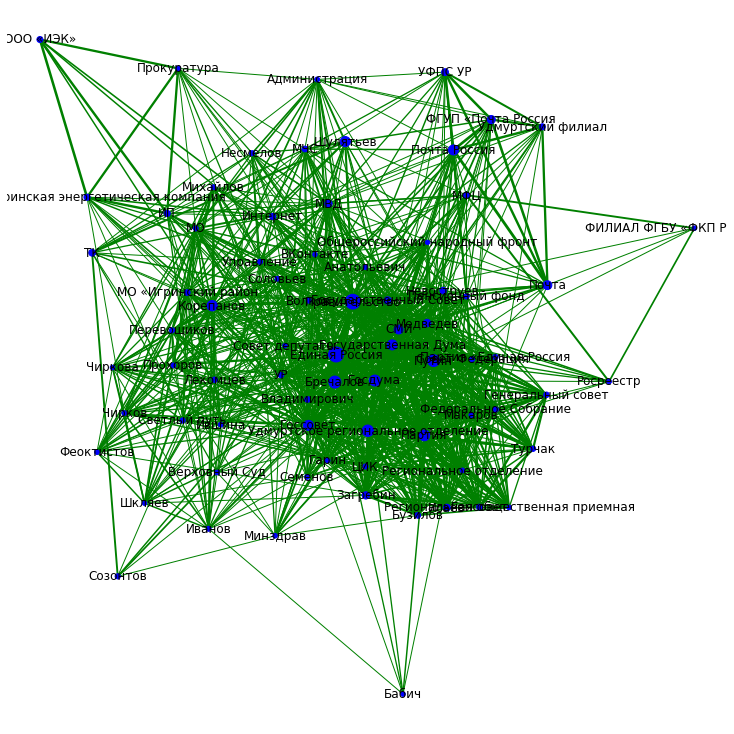

In [58]:
plt.figure(figsize = (10,10))
drawASocialGraph(G1, entities, names)
plt.show()

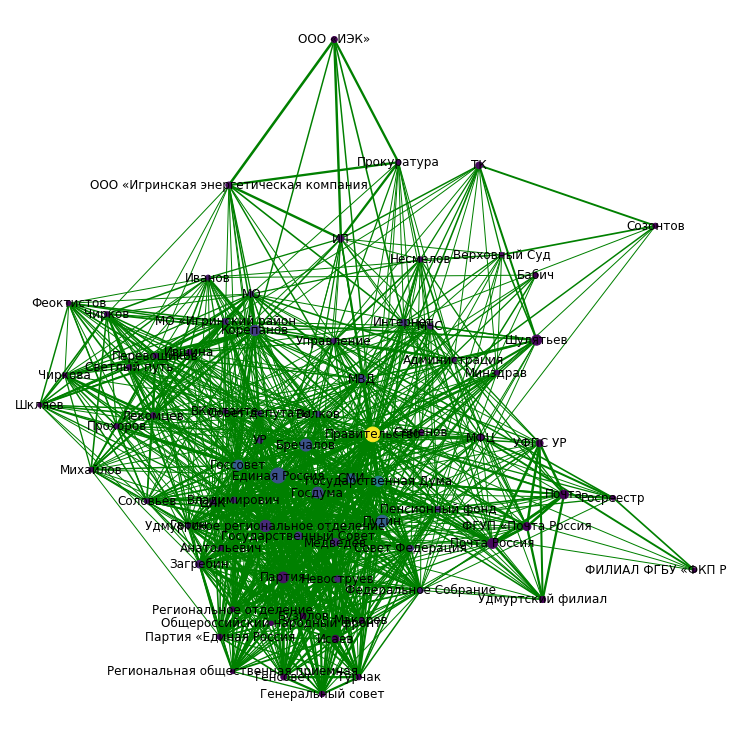

In [59]:
bb = nx.betweenness_centrality(G1)
nx.set_node_attributes(G1, bb, 'betweenness')

plt.figure(figsize = (10,10))
gclr=[bb[i] for i in G1.nodes()]
drawASocialGraph(G1, entities, names, gclr)
plt.show()

In [60]:
cls = nx.clustering(G1)
top10 = dict(sorted(cls.items(), key = itemgetter(1), reverse = True)[:10])
for item in top10.items():
    print(item[0], ':', '{:.4f}'.format(float(item[1])))

ФИЛИАЛ ФГБУ «ФКП РОСРЕЕСТРА» : 1.0000
Региональная общественная приемная : 0.9601
Турчак : 0.9233
Генсовет : 0.9060
Генеральный совет : 0.9051
Региональное отделение : 0.8874
Исаев : 0.8719
Партия «Единая Россия : 0.8667
ООО «ИЭК» : 0.8667
Бузилов : 0.8424
